In [1]:
import sys
print(sys.version)
print(sys.executable)

3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC v.1940 64 bit (AMD64)]
c:\Users\asvdi\AppData\Local\Programs\Python\Python312\python.exe


In [2]:
import numpy
import pandas
import torch
print("All libraries loaded successfully ✅")

All libraries loaded successfully ✅


In [3]:
import numpy as np
import pandas as pd

np.random.seed(42)

n = 1500
time = np.arange(n)

values = np.sin(0.02 * time) + np.random.normal(0, 0.1, n)
anomalies = np.zeros(n)

for i in [300, 700, 1200]:
    values[i:i+10] += np.random.uniform(3, 5)
    anomalies[i:i+10] = 1

df = pd.DataFrame({
    "value": values,
    "label": anomalies
})

df.to_csv("../data/timeseries.csv", index=False)
print("Dataset generated and saved.")


Dataset generated and saved.


In [4]:
df = pd.read_csv("../data/timeseries.csv")
df.head()

,value,label
0,0.049671,0.0
1,0.006172,0.0
2,0.104758,0.0
3,0.212267,0.0
4,0.056499,0.0


In [5]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
df["value"] = scaler.fit_transform(df[["value"]])

In [6]:
train_size = int(0.7 * len(df))
train_df = df.iloc[:train_size]
test_df = df.iloc[train_size:]

In [7]:
import torch
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, data, window_size):
        self.data = data.values
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        window = self.data[idx:idx+self.window_size, 0]
        return torch.tensor(window).unsqueeze(-1).float()

In [8]:
from torch.utils.data import DataLoader

WINDOW_SIZE = 30
BATCH_SIZE = 32

train_dataset = TimeSeriesDataset(train_df[["value"]], WINDOW_SIZE)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# if we want the model code seperate which is declared in ../model/transformer_model.ipynb directly,
# we can use it by uncommenting below line and commenting below cell. 
# from model.transformer_model import TransformerAnomalyDetector 

In [9]:
import torch.nn as nn
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=500):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        self.pe = pe.unsqueeze(0)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class TransformerAnomalyDetector(nn.Module):
    def __init__(self):
        super().__init__()
        self.embedding = nn.Linear(1, 64)
        self.positional_encoding = PositionalEncoding(64)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=4, batch_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=3)
        self.decoder = nn.Linear(64, 1)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        x = self.encoder(x)
        return self.decoder(x)

In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TransformerAnomalyDetector().to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

EPOCHS = 20

for epoch in range(EPOCHS):
    model.train()
    total_loss = 0

    for batch in train_loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        output = model(batch)
        loss = criterion(output, batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}/{EPOCHS} | Loss: {total_loss/len(train_loader):.6f}")

Epoch 1/20 | Loss: 0.415829
Epoch 2/20 | Loss: 0.024510
Epoch 3/20 | Loss: 0.020872
Epoch 4/20 | Loss: 0.013217
Epoch 5/20 | Loss: 0.005187
Epoch 6/20 | Loss: 0.003820
Epoch 7/20 | Loss: 0.003243
Epoch 8/20 | Loss: 0.002771
Epoch 9/20 | Loss: 0.002089
Epoch 10/20 | Loss: 0.001620
Epoch 11/20 | Loss: 0.001312
Epoch 12/20 | Loss: 0.001223
Epoch 13/20 | Loss: 0.001143
Epoch 14/20 | Loss: 0.000990
Epoch 15/20 | Loss: 0.000909
Epoch 16/20 | Loss: 0.000868
Epoch 17/20 | Loss: 0.000769
Epoch 18/20 | Loss: 0.000732
Epoch 19/20 | Loss: 0.000710
Epoch 20/20 | Loss: 0.000683


In [11]:
model.eval()
errors = []

test_values = test_df["value"].values

with torch.no_grad():
    for i in range(len(test_values) - WINDOW_SIZE):
        window = torch.tensor(
            test_values[i:i+WINDOW_SIZE]
        ).unsqueeze(0).unsqueeze(-1).float().to(device)

        output = model(window)
        error = torch.mean((output - window) ** 2).item()
        errors.append(error)

In [12]:
import numpy as np

threshold = np.percentile(errors, 95)
predictions = [1 if e > threshold else 0 for e in errors]

In [13]:
from sklearn.metrics import precision_score, recall_score, f1_score

true_labels = test_df["label"].values[WINDOW_SIZE:]

precision = precision_score(true_labels, predictions)
recall = recall_score(true_labels, predictions)
f1 = f1_score(true_labels, predictions)

print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Precision: 0.047619047619047616
Recall: 0.1
F1 Score: 0.06451612903225806


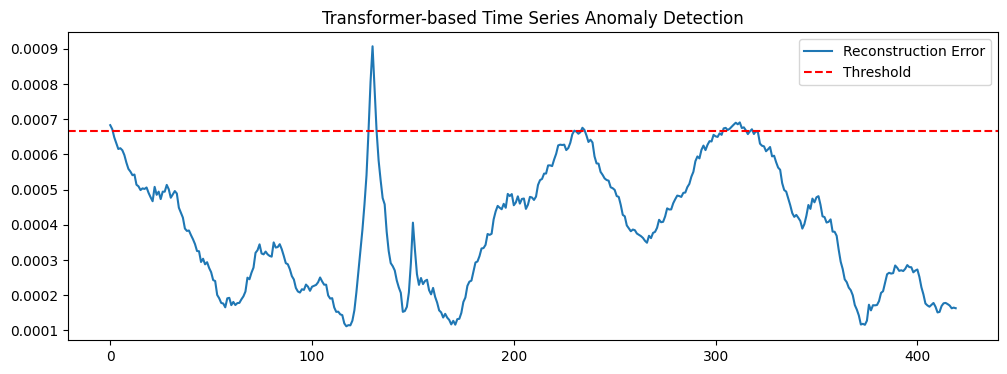

In [14]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,4))
plt.plot(errors, label="Reconstruction Error")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.legend()
plt.title("Transformer-based Time Series Anomaly Detection")
plt.show()

In [15]:
torch.save(model.state_dict(), "../checkpoints/transformer_anomaly.pth")
print("Model saved.")

Model saved.
